In [1]:
import h5py as h5
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import csv
import h5py
from torchvision.models import resnet18
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import warnings 
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
train_path = "/kaggle/input/deeplense-task1/dataset/train"
train_imgs = {}
for cat in os.listdir(train_path):
    sub_path = os.path.join(train_path,cat)
    imgs = []
    for img_path in os.listdir(sub_path):
        imgs.append(os.path.join(sub_path,img_path))
    train_imgs[cat] = imgs

In [3]:
val_path = "/kaggle/input/deeplense-task1/dataset/val"
val_imgs = {}
for cat in os.listdir(val_path):
    sub_path = os.path.join(val_path,cat)
    imgs = []
    for img_path in os.listdir(sub_path):
        imgs.append(os.path.join(sub_path,img_path))
    val_imgs[cat] = imgs

In [4]:
train_rows = [(img_path, label) for label, img_paths in train_imgs.items() for img_path in img_paths]
val_rows = [(img_path, label) for label, img_paths in val_imgs.items() for img_path in img_paths]

In [5]:
df_train = pd.DataFrame(train_rows, columns = ['img_path','label'])
df_val = pd.DataFrame(val_rows, columns = ['img_path','label'])

In [6]:
df_train['label'] = df_train['label'].map({'no':0, 'sphere':1, 'vort':2})
df_val['label'] = df_val['label'].map({'no':0, 'sphere':1, 'vort':2})

In [7]:
class Dataset(nn.Module):
    def __init__(self,data,transform = None, train = True):
        self.data = data
        self.imgs = [np.load(img_path) for img_path in self.data['img_path']]
        self.y = torch.tensor(self.data['label'], dtype = torch.long)
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.imgs[idx].squeeze()[:,:,np.newaxis]
        label = self.y[idx]
        img = np.tile(img,(1,1,3))
        if self.transform != None:
            img = self.transform(image = img)["image"]

        return img, label

In [24]:
train_transform = A.Compose([
    # A.RandomRotate90(p=0.5),
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
    # A.Normalize(mean=(0.485, 0.456, 0.406), 
    #             std=(0.229, 0.224, 0.225)),
    A.Resize(224,224),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224,224),
    ToTensorV2()
])

In [25]:
train_dataset = Dataset(df_train, train_transform)
val_dataset = Dataset(df_val, val_transform)

In [26]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False, num_workers = 0)

In [36]:
def get_pretrained_baseline(model_name, num_classes, pretrained=True):
    model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
    return model

def train_baseline(model, train_loader, val_loader, num_epochs=10, device='cuda'):
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accs, train_aucs = [], [], []
    val_losses, val_accs, val_aucs = [], [], []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss, total, correct = 0.0, 0, 0
        all_preds, all_labels = [], []
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            images, labels = images.to(device).float(), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()
            all_preds.extend(outputs.softmax(dim=1).detach().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            del images, labels, outputs, preds, loss
        train_loss = total_loss / total
        train_acc = correct / total
        train_auc = roc_auc_score(all_labels, all_preds, multi_class='ovr')
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_aucs.append(train_auc)
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Acc {train_acc:.4f}, AUC {train_auc:.4f}")
        
        model.eval()
        total_loss, total, correct = 0.0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                images, labels = images.to(device).float(), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * images.size(0)
                _, preds = outputs.max(1)
                total += labels.size(0)
                correct += preds.eq(labels).sum().item()
                all_preds.extend(outputs.softmax(dim=1).cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                del images, labels, outputs, preds, loss
        val_loss = total_loss / total
        val_acc = correct / total
        val_auc = roc_auc_score(all_labels, all_preds, multi_class='ovr')
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_aucs.append(val_auc)
        print(f"Epoch {epoch+1}: Val Loss {val_loss:.4f}, Acc {val_acc:.4f}, AUC {val_auc:.4f}")
    
    history = {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'train_auc': train_aucs,
        'val_loss': val_losses,
        'val_acc': val_accs,
        'val_auc': val_aucs
    }
    return history

def plot_curves(history, title_prefix="Baseline"):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train')
    plt.plot(epochs, history['val_loss'], label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"{title_prefix} Loss")
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train')
    plt.plot(epochs, history['val_acc'], label='Val')
    plt.xlabel('Epoch')
    plt.ylabel

Epoch 1/10 [Train]: 100%|██████████| 938/938 [02:06<00:00,  7.40it/s]


Epoch 1: Train Loss 1.0194, Acc 0.5268, AUC 0.7164


Epoch 1/10 [Val]: 100%|██████████| 235/235 [00:12<00:00, 19.51it/s]


Epoch 1: Val Loss 0.6531, Acc 0.7227, AUC 0.8880


Epoch 2/10 [Train]: 100%|██████████| 938/938 [02:06<00:00,  7.42it/s]


Epoch 2: Train Loss 0.4607, Acc 0.8176, AUC 0.9380


Epoch 2/10 [Val]: 100%|██████████| 235/235 [00:11<00:00, 19.86it/s]


Epoch 2: Val Loss 0.3591, Acc 0.8588, AUC 0.9614


Epoch 3/10 [Train]: 100%|██████████| 938/938 [02:06<00:00,  7.41it/s]


Epoch 3: Train Loss 0.3137, Acc 0.8830, AUC 0.9703


Epoch 3/10 [Val]: 100%|██████████| 235/235 [00:11<00:00, 19.88it/s]


Epoch 3: Val Loss 0.3035, Acc 0.8901, AUC 0.9746


Epoch 4/10 [Train]: 100%|██████████| 938/938 [02:07<00:00,  7.38it/s]


Epoch 4: Train Loss 0.2643, Acc 0.9041, AUC 0.9782


Epoch 4/10 [Val]: 100%|██████████| 235/235 [00:11<00:00, 19.59it/s]


Epoch 4: Val Loss 0.2781, Acc 0.8975, AUC 0.9819


Epoch 5/10 [Train]: 100%|██████████| 938/938 [02:06<00:00,  7.40it/s]


Epoch 5: Train Loss 0.2260, Acc 0.9191, AUC 0.9838


Epoch 5/10 [Val]: 100%|██████████| 235/235 [00:11<00:00, 19.79it/s]


Epoch 5: Val Loss 0.3214, Acc 0.8963, AUC 0.9796


Epoch 6/10 [Train]: 100%|██████████| 938/938 [02:07<00:00,  7.36it/s]


Epoch 6: Train Loss 0.1985, Acc 0.9294, AUC 0.9871


Epoch 6/10 [Val]: 100%|██████████| 235/235 [00:12<00:00, 18.77it/s]


Epoch 6: Val Loss 0.3146, Acc 0.8991, AUC 0.9782


Epoch 7/10 [Train]: 100%|██████████| 938/938 [02:07<00:00,  7.34it/s]


Epoch 7: Train Loss 0.1831, Acc 0.9351, AUC 0.9891


Epoch 7/10 [Val]: 100%|██████████| 235/235 [00:12<00:00, 19.48it/s]


Epoch 7: Val Loss 0.2577, Acc 0.9108, AUC 0.9827


Epoch 8/10 [Train]: 100%|██████████| 938/938 [02:07<00:00,  7.36it/s]


Epoch 8: Train Loss 0.1644, Acc 0.9419, AUC 0.9911


Epoch 8/10 [Val]: 100%|██████████| 235/235 [00:12<00:00, 19.34it/s]


Epoch 8: Val Loss 0.2880, Acc 0.9101, AUC 0.9836


Epoch 9/10 [Train]: 100%|██████████| 938/938 [02:06<00:00,  7.39it/s]


Epoch 9: Train Loss 0.1494, Acc 0.9477, AUC 0.9924


Epoch 9/10 [Val]: 100%|██████████| 235/235 [00:11<00:00, 19.93it/s]


Epoch 9: Val Loss 0.1957, Acc 0.9336, AUC 0.9882


Epoch 10/10 [Train]: 100%|██████████| 938/938 [02:06<00:00,  7.41it/s]


Epoch 10: Train Loss 0.1295, Acc 0.9551, AUC 0.9944


Epoch 10/10 [Val]: 100%|██████████| 235/235 [00:11<00:00, 19.84it/s]


Epoch 10: Val Loss 0.2997, Acc 0.8905, AUC 0.9810


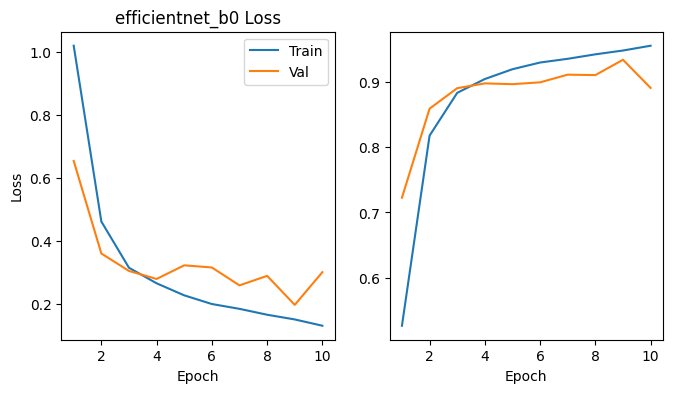

In [39]:
num_classes = 3
model_name = 'efficientnet_b0'
baseline_model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
history = train_baseline(baseline_model, train_loader, val_loader, num_epochs=10, device='cuda')
plot_curves(history, title_prefix=model_name)